# Setup do Projeto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Carregando os Dados

In [2]:
df = pd.read_csv("datasets/inflacao.csv")

In [3]:
df.describe()

,ano,mes,ano_mes,ipca_variacao,ipca_acumulado_ano,ipca_acumulado_doze_meses,ipca15_variacao,ipca15_acumulado_ano,ipca15_acumulado_doze_meses,inpc_variacao,inpc_acumulado_ano,inpc_acumulado_doze_meses,ipa_variacao,ipa_acumulado_ano,ipc_fipe_variacao,ipc_fipe_acumulado_ano,incc_variacao,incc_acumulado_ano,salario_minimo
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,5.160000e+02
mean,2001.000000,6.500000,200106.500000,5.937888,96.319922,309.499283,0.270252,1.862946,3.385756,5.926860,95.823798,308.536764,6.161492,41.321008,5.777074,38.766647,6.095465,41.864535,5.532230e+04
std,12.421716,3.455402,1242.176409,10.854106,265.746885,863.982930,0.392440,2.417374,3.813378,10.860182,262.990305,850.065817,11.039162,73.714576,10.770582,72.693704,11.211912,73.743783,3.253307e+05
min,1980.000000,1.000000,198001.000000,-0.680000,-0.160000,0.000000,-0.730000,0.000000,0.000000,-0.600000,0.060000,0.000000,-2.420000,-5.820000,-1.000000,-1.790000,-0.500000,0.310000,5.437000e+01
25%,1990.000000,3.750000,199009.750000,0.380000,2.487500,5.255000,0.000000,0.000000,0.000000,0.387500,2.592500,5.412500,0.267500,2.217500,0.300000,1.997500,0.360000,2.900000,2.400000e+02
50%,2001.000000,6.500000,200106.500000,0.780000,5.240000,7.770000,0.055000,0.660000,2.800000,0.815000,5.220000,8.965000,1.355000,7.545000,0.740000,4.915000,0.880000,6.585000,7.240000e+02
75%,2012.000000,9.250000,201203.250000,6.840000,48.730000,156.785000,0.490000,3.282500,6.202500,6.732500,46.067500,159.232500,7.312500,42.997500,6.715000,39.445000,5.985000,45.912500,3.674060e+03
max,2022.000000,12.000000,202212.000000,82.390000,2477.150000,6821.310000,3.050000,11.990000,17.240000,82.180000,2489.110000,6554.520000,82.040000,381.830000,79.110000,374.660000,78.410000,388.770000,4.639800e+06


### Formatando o index para a análise preditiva

In [4]:
df.index = pd.to_datetime(df['referencia'], format='%Y-%m-%d')

In [5]:
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='referencia', length=516, freq=None)

In [6]:
df.head()

,referencia,ano,mes,ano_mes,ipca_variacao,ipca_acumulado_ano,ipca_acumulado_doze_meses,ipca15_variacao,ipca15_acumulado_ano,ipca15_acumulado_doze_meses,...,inpc_acumulado_ano,inpc_acumulado_doze_meses,ipa_variacao,ipa_acumulado_ano,ipc_fipe_variacao,ipc_fipe_acumulado_ano,incc_variacao,incc_acumulado_ano,salario_minimo,consolidado_ano
referencia,,,,,,,,,,,,,,,,,,,,,
1980-01-01,1980-01,1980,1,198001,6.62,6.62,0.0,0.0,0.0,0.0,...,6.56,0.00,7.31,7.31,4.48,4.48,4.70,4.70,2932.8,False
1980-02-01,1980-02,1980,2,198002,4.62,11.54,0.0,0.0,0.0,0.0,...,10.98,0.00,3.69,11.00,3.35,7.83,9.53,14.23,2932.8,False
1980-03-01,1980-03,1980,3,198003,6.04,18.27,0.0,0.0,0.0,0.0,...,16.67,75.11,6.32,17.32,4.34,12.17,12.80,27.03,2932.8,False
1980-04-01,1980-04,1980,4,198004,5.29,24.53,0.0,0.0,0.0,0.0,...,22.33,77.48,6.69,24.01,3.93,16.10,3.13,30.16,2932.8,False
1980-05-01,1980-05,1980,5,198005,5.70,31.63,0.0,0.0,0.0,0.0,...,29.10,84.06,7.32,31.33,6.52,22.62,4.86,35.02,4149.6,False


### Pegando uma amostra recente dos dados

In [7]:
df_analise = df[df['ano'] >= 1995]

In [8]:
df_analise.shape

(336, 21)

In [9]:
df_analise = df_analise.ipca_variacao

In [10]:
df_analise.shape

(336,)

### Criando o Dataset de Treino e Teste

In [11]:
train = df_analise[df_analise.index <= pd.to_datetime("2022-03-01", format='%Y-%m-%d')]
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

In [12]:
train.shape

(327,)

In [13]:
test = df_analise[df_analise.index >= pd.to_datetime("2022-03-01", format='%Y-%m-%d')]
test.index = pd.DatetimeIndex(test.index.values,
                               freq=test.index.inferred_freq)

In [14]:
test.shape

(10,)

## Análise com o Autoarima

* Gerando um gráfico para criar uma referencia visual do treino

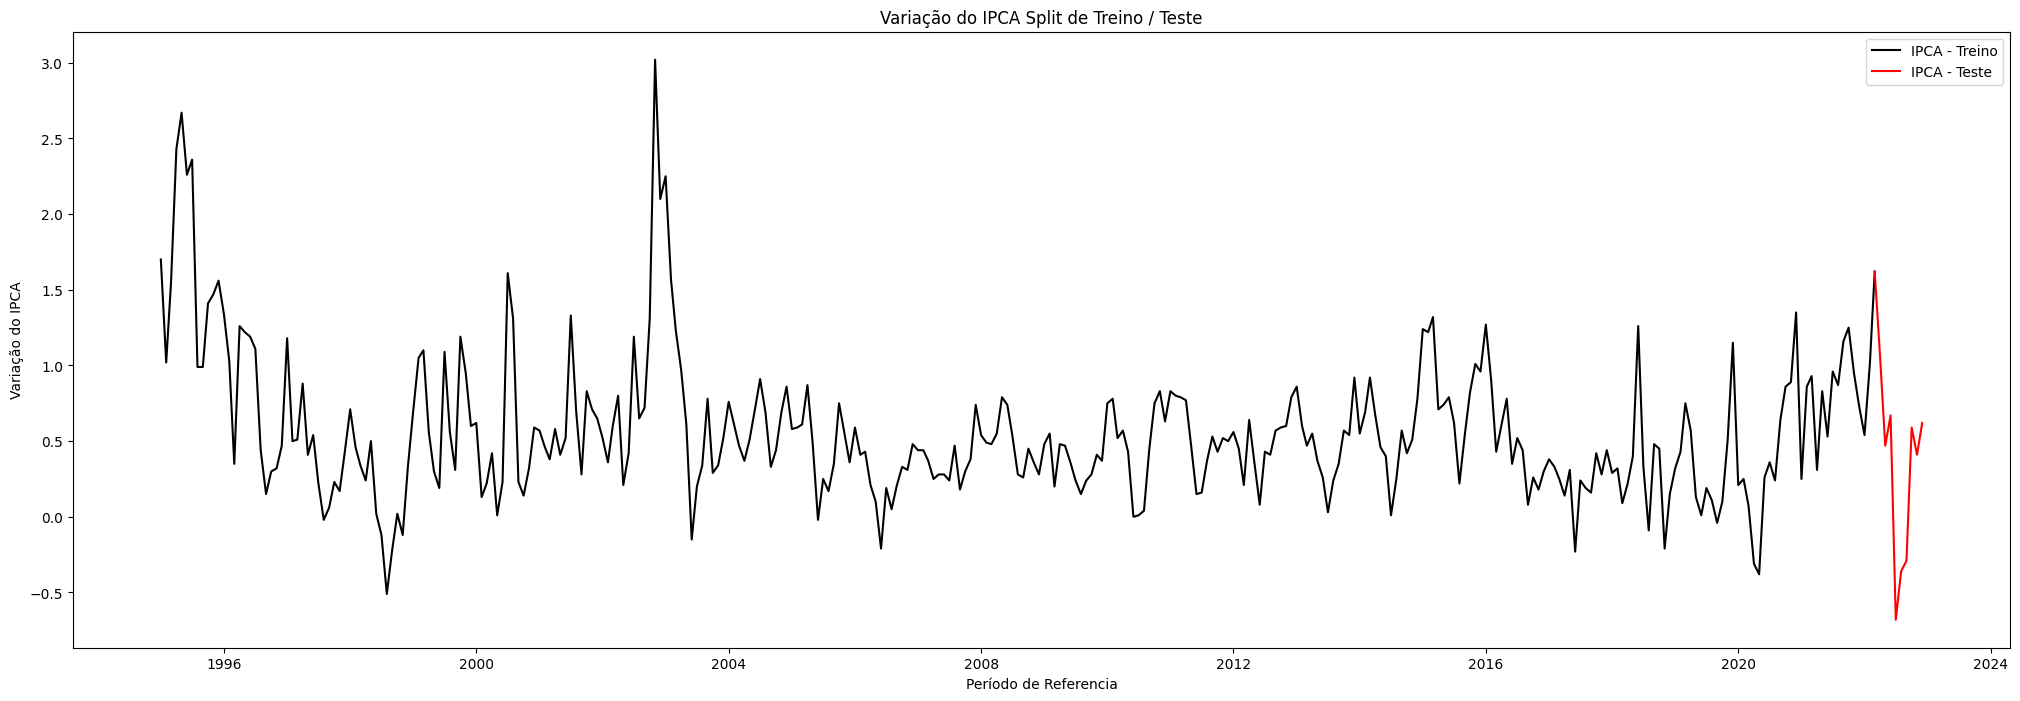

In [15]:
plt.figure(figsize=(25, 8))
plt.plot(train, label="IPCA - Treino", color='black')
plt.plot(test, label="IPCA - Teste", color='red')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")


plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

* Encontrando o fit do melhor modelo para ARIMA / SARIMA

In [16]:
sarima_model = auto_arima(train, start_p=0, start_q=0, start_P=0, start_Q=0, start_D=0,
                     max_p=6, max_q=6, max_P=6, max_Q=6, max_D=6, seasonal=True,
                     stepwise=False, suppress_warnings=True,
                     error_action='ignore', m=12, trace=True)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=257.120, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=243.941, Time=0.29 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=243.819, Time=0.49 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=242.991, Time=0.86 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=244.804, Time=1.74 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=245.737, Time=3.95 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=241.491, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=237.676, Time=0.28 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=238.561, Time=0.80 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=240.362, Time=1.91 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=242.353, Time=5.29 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=241.699, Time=0.19 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=238.658, Time=0.56 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(3,0,

 ARIMA(5,1,0)(0,0,0)[12] intercept   : AIC=227.864, Time=0.08 sec

Best model:  ARIMA(1,1,2)(1,0,1)[12] intercept
Total fit time: 123.537 seconds


* Visualizado os dados do modelo gerado

In [17]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  327
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 -91.480
Date:                              Mon, 16 Jan 2023   AIC                            196.960
Time:                                      17:30:17   BIC                            223.468
Sample:                                  01-01-1995   HQIC                           207.538
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.301      0.763      -0.002       0.001
ar.L1          0.4333      0.109      3.962      0.000       0.219       0.648
ma.L1         -0.6995      0.120     -5.818      0.000      -0.935      -0.464
ma.L2         -0.1564      0.081     -1.939      0.053      -0.315       0.002
ar.S.L12       0.8514      0.100      8.541      0.000       0.656       1.047
ma.S.L12      -0.6983      0.129     -5.409      0.000      -0.951      -0.445
sigma2         0.1010      0.005     22.061      0.000       0.092       0.110
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               386.77
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Diagnósticos do modelo

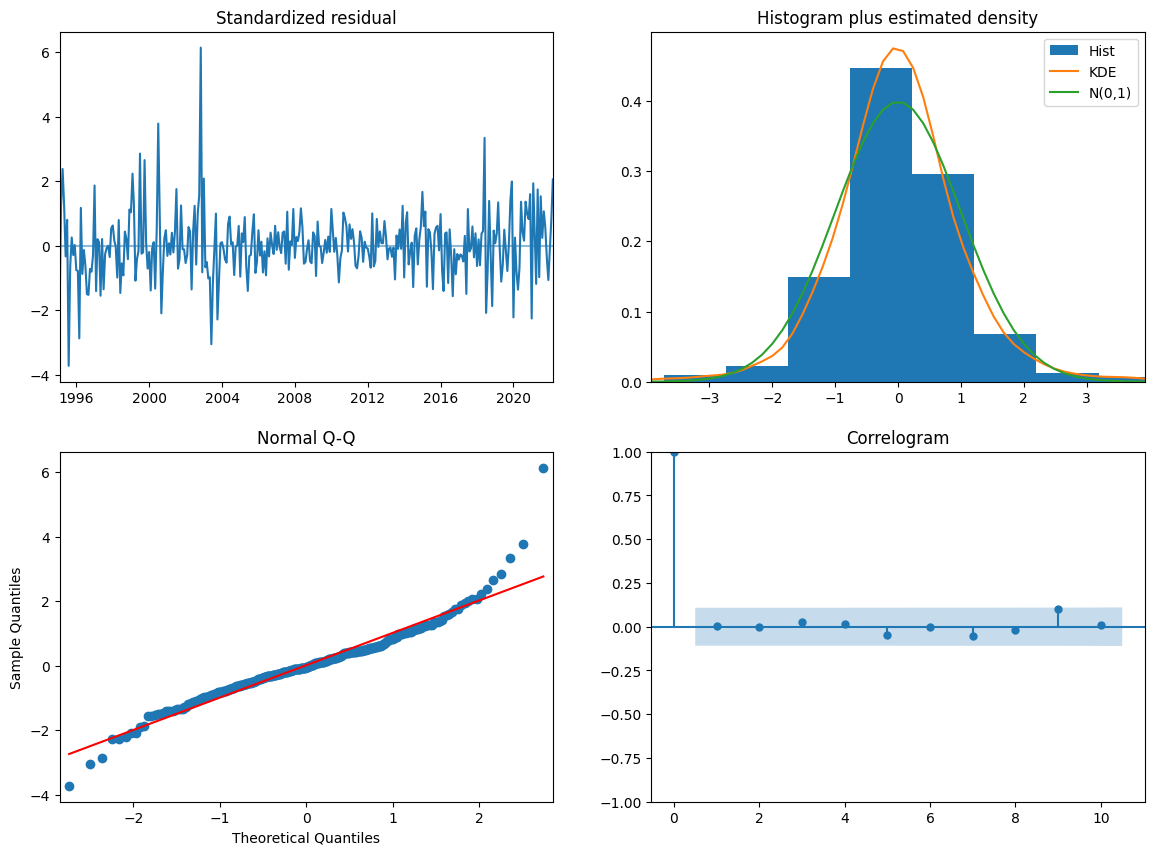

In [18]:
sarima_model.plot_diagnostics(figsize=(14,10))
plt.show()

### Criando um modelo com o fit previsto, utilizando a biblioteca do Sarima

In [19]:
SARIMAXmodel = SARIMAX(train, order = (1,1,2), seasonal_order=(1,0,1, 12), enforce_stationarity=True, enforce_invertibility=True)
SARIMAXmodel = SARIMAXmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02753D-01    |proj g|=  6.78613D-02

At iterate    5    f=  2.95680D-01    |proj g|=  4.54188D-02

At iterate   10    f=  2.85407D-01    |proj g|=  2.40175D-01

At iterate   15    f=  2.82291D-01    |proj g|=  4.05681D-03

At iterate   20    f=  2.80952D-01    |proj g|=  1.97808D-02

At iterate   25    f=  2.79892D-01    |proj g|=  2.84453D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     34      1     0     0   2.131D-06   2.798D-01
  F =  0.27984628273172152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


* Colocando a o teste no gráfico para visualização

In [20]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index

y_pred_out_sarima = y_pred_df["Predictions"] 

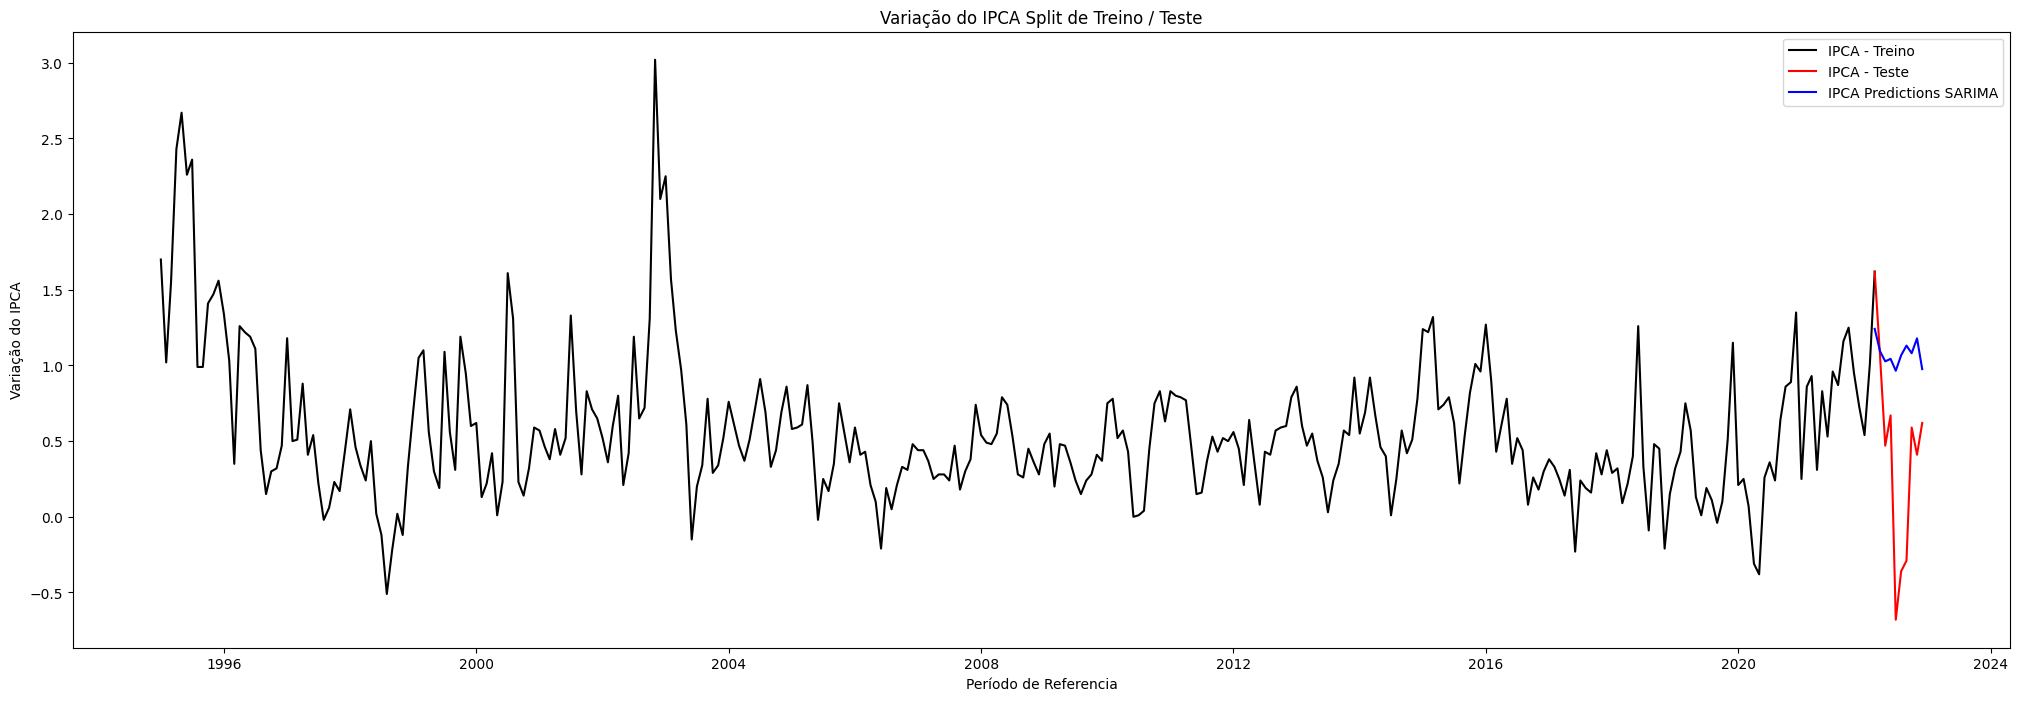

In [21]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

### Comparando com o modelo direto do Autosarima

In [22]:
prediction, confint = sarima_model.predict(n_periods=len(test.index), return_conf_int=True)
prediction

2022-04-01    1.233756
2022-05-01    1.080952
2022-06-01    1.013200
2022-07-01    1.029216
2022-08-01    0.950682
2022-09-01    1.050942
2022-10-01    1.113182
2022-11-01    1.062139
2022-12-01    1.157481
2023-01-01    0.954552
Freq: MS, dtype: float64

In [23]:
prediction_series = pd.Series(prediction,index=test.index)

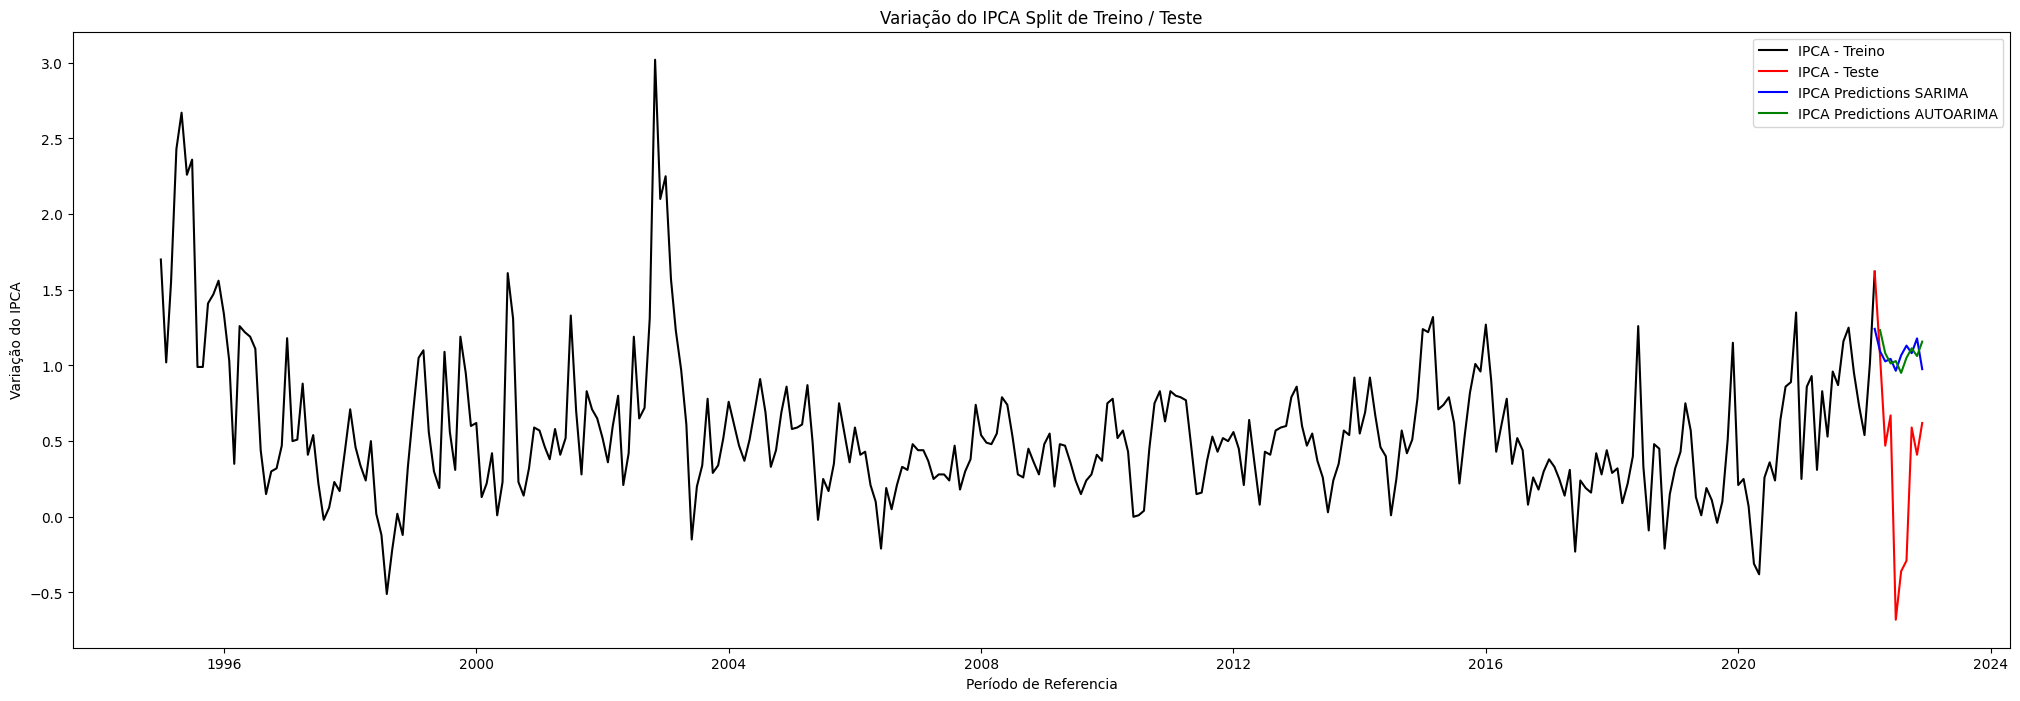

In [24]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')
plt.plot(prediction_series, color='Green', label = 'IPCA Predictions AUTOARIMA')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

In [25]:
prediction_sarimax = SARIMAXmodel.predict(start='2022-11-01',end='2024-12-01')

In [26]:
prediction_sarimax

2022-11-01    1.080931
2022-12-01    1.178816
2023-01-01    0.975553
2023-02-01    1.114246
2023-03-01    1.200279
2023-04-01    1.034911
2023-05-01    1.048704
2023-06-01    1.053756
2023-07-01    1.095404
2023-08-01    1.040443
2023-09-01    1.133067
2023-10-01    1.190177
2023-11-01    1.148382
2023-12-01    1.232432
2024-01-01    1.059087
2024-02-01    1.177601
2024-03-01    1.251101
2024-04-01    1.109922
2024-05-01    1.121706
2024-06-01    1.126024
2024-07-01    1.161586
2024-08-01    1.114659
2024-09-01    1.193745
2024-10-01    1.242508
2024-11-01    1.206822
2024-12-01    1.278586
Freq: MS, Name: predicted_mean, dtype: float64

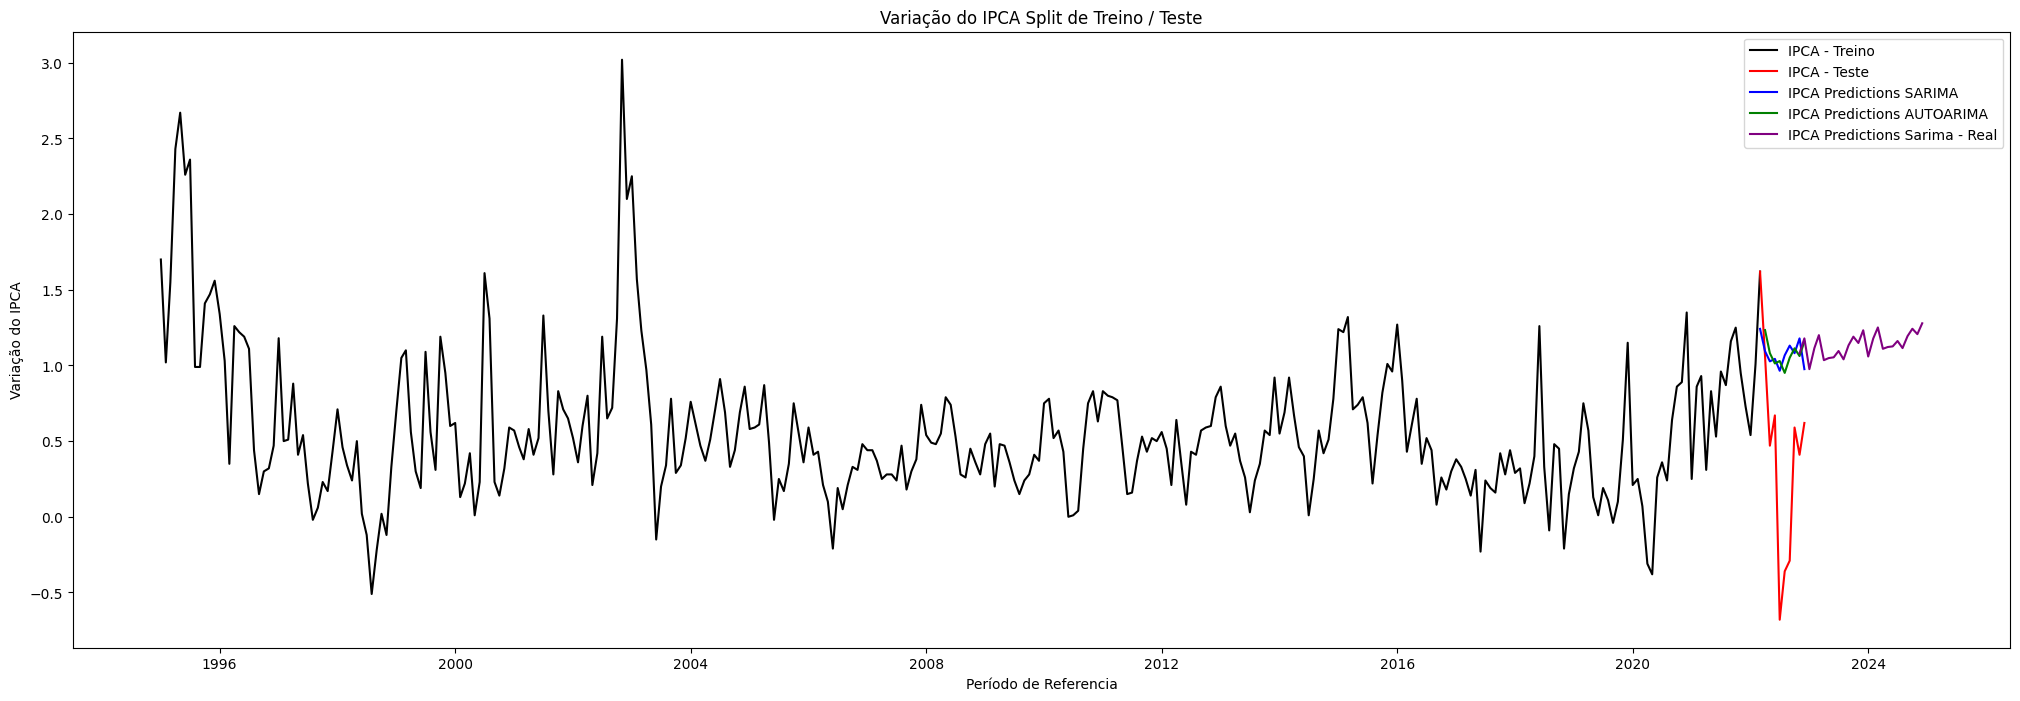

In [27]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')
plt.plot(prediction_series, color='Green', label = 'IPCA Predictions AUTOARIMA')

plt.plot(prediction_sarimax, color='Purple', label = 'IPCA Predictions Sarima - Real')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

In [28]:
cf= pd.DataFrame(confint)

In [29]:
cf

,0,1
0,0.610873,1.856639
1,0.308350,1.853554
2,0.188729,1.837671
3,0.177307,1.881125
4,0.079406,1.821959
5,0.163443,1.938440
6,0.210850,2.015515
7,0.145668,1.978610
8,0.227280,2.087683
9,0.010901,1.898203


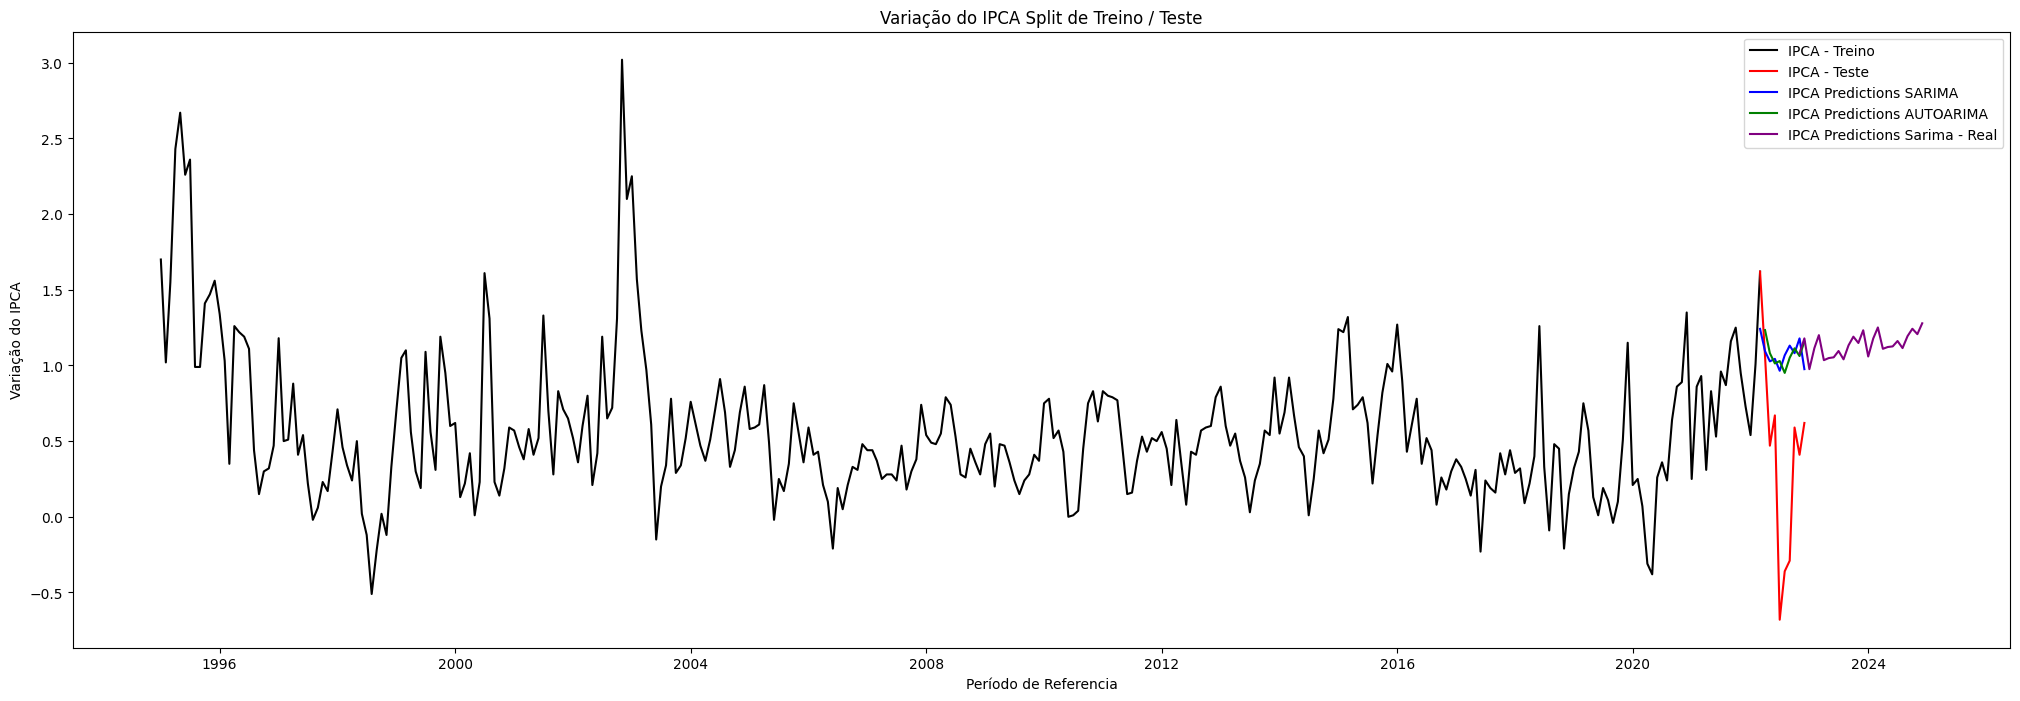

In [30]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')
plt.plot(prediction_series, color='Green', label = 'IPCA Predictions AUTOARIMA')

plt.plot(prediction_sarimax, color='Purple', label = 'IPCA Predictions Sarima - Real')


plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

## Realizando o treino com todos os dados

* Utilizando o autoarima mas com todos os dados da amostra, ou seja, treino + teste

In [31]:
sarima_model_analise = auto_arima(df_analise, start_p=0, start_q=0, start_P=0, start_Q=0, start_D=0,
                     max_p=6, max_q=6, max_P=6, max_Q=6, max_D=6, seasonal=True,
                     stepwise=False, suppress_warnings=True,
                     error_action='ignore', m=12, trace=True)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=281.959, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=271.937, Time=0.31 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=271.446, Time=0.61 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=271.087, Time=1.01 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=271.415, Time=1.89 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=272.957, Time=2.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=269.693, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=263.434, Time=0.14 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=265.039, Time=1.22 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=266.793, Time=2.10 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=268.616, Time=4.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=269.157, Time=0.29 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=265.073, Time=0.53 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(3,0,

In [32]:
analise_model = SARIMAX(df_analise, order = (2,1,1), seasonal_order=(1,0,1, 12), enforce_stationarity=True, enforce_invertibility=True)
analise_model = analise_model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54999D-01    |proj g|=  7.10736D-02

At iterate    5    f=  3.49595D-01    |proj g|=  7.37624D-02

At iterate   10    f=  3.18190D-01    |proj g|=  9.58396D-02

At iterate   15    f=  3.09693D-01    |proj g|=  5.52367D-03

At iterate   20    f=  3.09090D-01    |proj g|=  5.02915D-03

At iterate   25    f=  3.09035D-01    |proj g|=  8.94949D-04

At iterate   30    f=  3.08895D-01    |proj g|=  1.24472D-02

At iterate   35    f=  3.08112D-01    |proj g|=  5.14994D-03

At iterate   40    f=  3.08104D-01    |proj g|=  9.32112D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

* Realizando a previsão dos proximos valores

In [33]:
prediction_analise = analise_model.predict(start='2022-12-01',end='2024-12-01')

In [34]:
prediction_analise

2022-12-01    0.564768
2023-01-01    0.431090
2023-02-01    0.578549
2023-03-01    0.666815
2023-04-01    0.476832
2023-05-01    0.427276
2023-06-01    0.474764
2023-07-01    0.312223
2023-08-01    0.314109
2023-09-01    0.409271
2023-10-01    0.595582
2023-11-01    0.533653
2023-12-01    0.645464
2024-01-01    0.467908
2024-02-01    0.589618
2024-03-01    0.661549
2024-04-01    0.490057
2024-05-01    0.443458
2024-06-01    0.483194
2024-07-01    0.338525
2024-08-01    0.339126
2024-09-01    0.422198
2024-10-01    0.585780
2024-11-01    0.530846
2024-12-01    0.629067
Freq: MS, Name: predicted_mean, dtype: float64

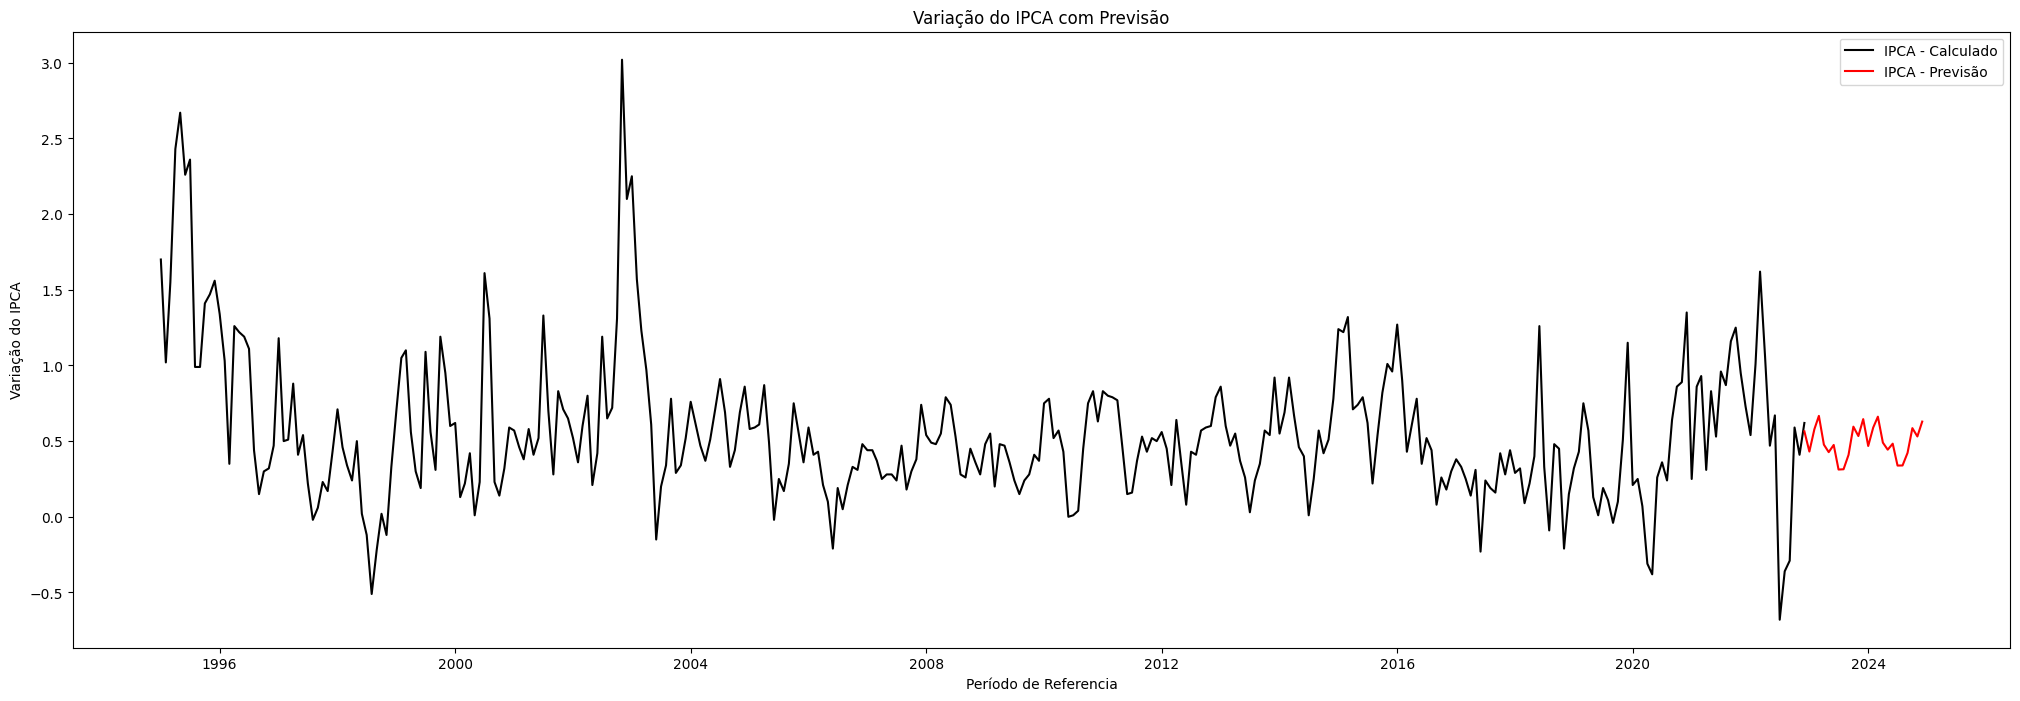

In [35]:
plt.figure(figsize=(25, 8))
plt.plot(df_analise, label="IPCA - Calculado", color='black')
plt.plot(prediction_analise, label="IPCA - Previsão", color='red')


plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA com Previsão")
plt.legend()
plt.show()